In [1]:
import geopandas as gpd

shapefile_path = 'nyc_taxi_zones/geo_export_256ac8cd-854b-4df2-8b77-35675aff5e3d.shp'
taxi_zones = gpd.read_file(shapefile_path)
manhattan_zones = taxi_zones[taxi_zones['borough'] == 'Manhattan']
manhattan_zones.head(5)

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
9,Manhattan,24.0,24.0,0.000061,0.047000,Bloomingdale,"POLYGON ((-73.95954 40.79872, -73.96004 40.798..."
12,Manhattan,12.0,12.0,0.000042,0.036661,Battery Park,"POLYGON ((-74.01566 40.70483, -74.01540 40.704..."
13,Manhattan,13.0,13.0,0.000149,0.050281,Battery Park City,"POLYGON ((-74.01244 40.71906, -74.01282 40.717..."
40,Manhattan,41.0,41.0,0.000143,0.052793,Central Harlem,"POLYGON ((-73.94774 40.80960, -73.94506 40.808..."


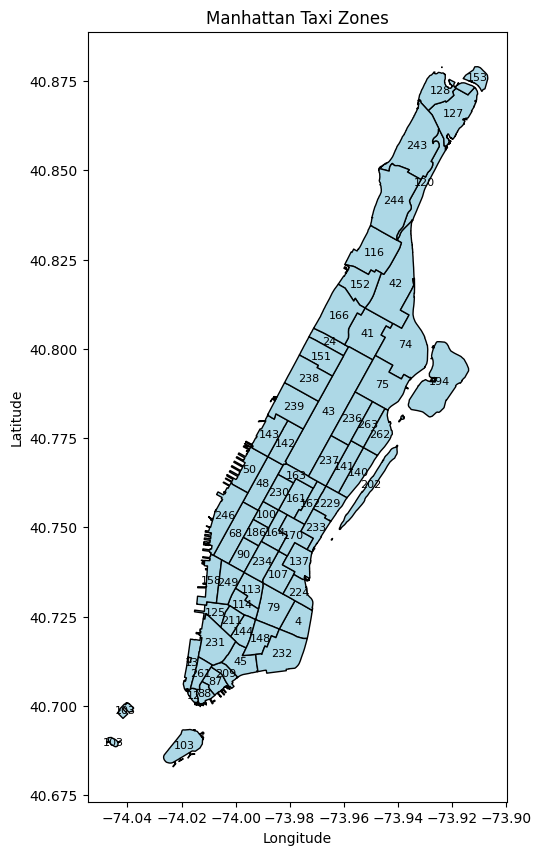

In [2]:
import matplotlib.pyplot as plt

manhattan_zones = manhattan_zones.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

manhattan_zones.plot(ax=ax, color='lightblue', edgecolor='black')

for idx, row in manhattan_zones.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(int(row['location_i'])), fontsize=8, ha='center', va='center', color='black')

ax.set_title('Manhattan Taxi Zones')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [3]:
import pandas as pd
from shapely.geometry import Polygon

manhattan_zones['bbox'] = manhattan_zones.geometry.apply(lambda x: x.bounds)

grid_info = pd.read_csv('grid_info.csv')

results = []

for index, row in grid_info.iterrows():
    if row['intersects_manhattan']:
        cell_bbox = Polygon([
            (row['min_lon'], row['min_lat']),
            (row['max_lon'], row['min_lat']),
            (row['max_lon'], row['max_lat']),
            (row['min_lon'], row['max_lat']),
            (row['min_lon'], row['min_lat'])
        ])
        
        total_area = cell_bbox.area
        intersections = {}

        for _, zone in manhattan_zones.iterrows():
            zone_bbox = Polygon([
                (zone['bbox'][0], zone['bbox'][1]),
                (zone['bbox'][2], zone['bbox'][1]),
                (zone['bbox'][2], zone['bbox'][3]),
                (zone['bbox'][0], zone['bbox'][3]),
                (zone['bbox'][0], zone['bbox'][1])
            ])
            
            if cell_bbox.intersects(zone_bbox):
                intersection = cell_bbox.intersection(zone.geometry)
                intersection_area = intersection.area
                if intersection_area > 0:
                    intersections[zone['location_i']] = intersection_area / total_area
        
        row['taxi_zones'] = intersections
    else:
        row['taxi_zones'] = {}
    
    results.append(row)

results_df = pd.DataFrame(results)

In [4]:
results_df.head(10)

,grid_code,min_lon,max_lon,min_lat,max_lat,intersects_manhattan,has_sensor,sensor_list,taxi_zones
0,0@0,-74.04353,-74.03853,40.652917,40.657917,False,False,[],{}
1,0@1,-74.04353,-74.03853,40.657917,40.662917,False,False,[],{}
2,0@2,-74.04353,-74.03853,40.662917,40.667916,False,False,[],{}
3,0@3,-74.04353,-74.03853,40.667916,40.672917,False,False,[],{}
4,0@4,-74.04353,-74.03853,40.672917,40.677917,False,False,[],{}
5,0@5,-74.04353,-74.03853,40.677917,40.682917,False,False,[],{}
6,0@6,-74.04353,-74.03853,40.682917,40.687917,False,False,[],{}
7,0@7,-74.04353,-74.03853,40.687917,40.692917,True,False,[],{103.0: 0.0038255470545629972}
8,0@8,-74.04353,-74.03853,40.692917,40.697917,True,False,[],{103.0: 0.11251532411619608}
9,0@9,-74.04353,-74.03853,40.697917,40.702917,True,False,[],{103.0: 0.33618259897708513}


In [5]:
results_df.to_csv('grid_info_full_ver.csv', index=False)

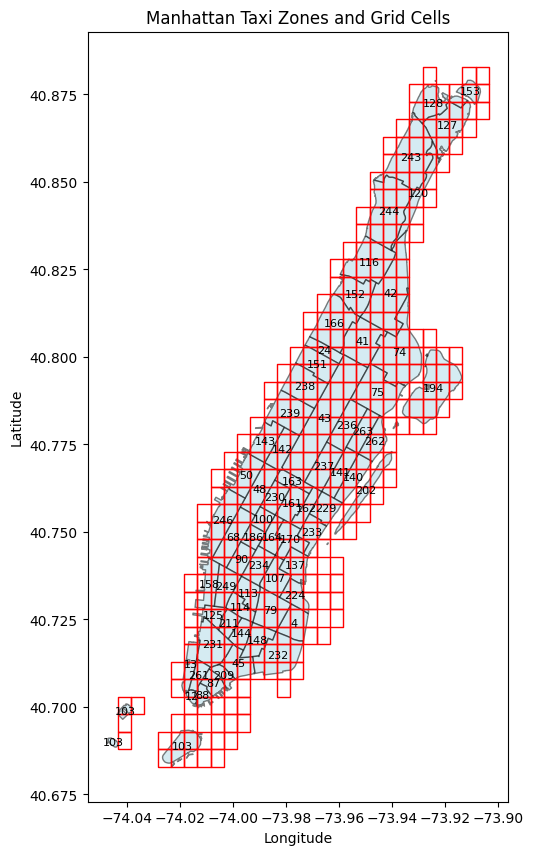

In [6]:
grid_cells = []

for index, row in grid_info.iterrows():
    if row['intersects_manhattan']:
        cell_bbox = Polygon([
            (row['min_lon'], row['min_lat']),
            (row['max_lon'], row['min_lat']),
            (row['max_lon'], row['max_lat']),
            (row['min_lon'], row['max_lat']),
            (row['min_lon'], row['min_lat'])
        ])
        grid_cells.append({
            'grid_code': row['grid_code'],
            'geometry': cell_bbox
        })

grid_gdf = gpd.GeoDataFrame(grid_cells, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

manhattan_zones.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

grid_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=1)

for idx, row in manhattan_zones.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(int(row['location_i'])), fontsize=8, ha='center', va='center', color='black')

ax.set_title('Manhattan Taxi Zones and Grid Cells')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [7]:
results_df[results_df['grid_code'] == '14@26']

,grid_code,min_lon,max_lon,min_lat,max_lat,intersects_manhattan,has_sensor,sensor_list,taxi_zones
726,14@26,-73.97353,-73.96853,40.782917,40.787917,True,True,[144714],"{43.0: 0.176858415045112, 239.0: 0.46425677371..."
